In [1]:
import pandas
import numpy as np
import re, os
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import unicodedata
from nltk import pos_tag
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile, f_classif
from sklearn.cross_validation import train_test_split
from string import ascii_lowercase as al
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import zero_one_loss,f1_score,jaccard_similarity_score
from sklearn.pipeline import Pipeline
from fuzzywuzzy import fuzz,process
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from nltk.tag.stanford import StanfordPOSTagger
import operator
from gensim.models import Doc2Vec, Word2Vec
from gensim.models.doc2vec import LabeledSentence
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.mixture import GMM,VBGMM
from itertools import chain,combinations
import treetaggerwrapper
from scipy.sparse import csr_matrix

%matplotlib inline

PATH = 'C:/Users/MACH055/Documents/Data/'

def load_data_xls(file_name,src,sheet_name,verbatim_column, target_columns, default_sentiment,ax, show_hist=False,
                  path='C:/Users/MACH055/Documents/Data/'):
    
    data = pandas.read_excel(path+file_name,sheet_name=sheet_name)
    
    take_categories = ('categories' in target_columns)
    take_sentiments = ('sentiments' in target_columns)
    
    
    verbatims = data[verbatim_column]
    src_col = pandas.Series(np.repeat(src,len(verbatims)))
    
    columns= {'verbatims':verbatims,'src':src_col}
    
    if take_categories:
        y_cat = data[target_columns['categories']]
        columns.update({'categories':y_cat})
    if take_sentiments : 
        y_sa = data[target_columns['sentiments']].str.lower()
        columns.update({'sentiments' :y_sa})
    
    # Charger les donnees dans un DataFrame
    data_filtered = pandas.DataFrame(columns)
    
    # Supprimer les observations sans verbatims 
    verbatims_notnull = np.where(pandas.isnull(verbatims))
    data_filtered = data_filtered.drop(verbatims_notnull[0])
    data_filtered = data_filtered.reset_index(drop=True)
    
    # Si vide, remplir les targets de sentiments par la valeur par défaut
    if take_sentiments:
        data_filtered["sentiments"][pandas.isnull(data_filtered["sentiments"])] = default_sentiment
    
    # Afficher les histogrammes des categories et des sentiments
    if show_hist :
        ax[0].bar(range(len(data_filtered["categories"].value_counts())),data_filtered["categories"].value_counts(), 
                  orientation='vertical')
        #ax[0].set_xticklabels(np.unique(data_filtered["categories"]), rotation ="vertical")
        
        ax[1].bar(range(len(data_filtered["sentiments"].value_counts())),data_filtered["sentiments"].value_counts(), 
                  orientation='vertical',tick_label=data_filtered["sentiments"].value_counts().index)
        #ax[1].set_xticklabels(np.unique(data_filtered["sentiments"]), rotation ="vertical",tick_label=data_filtered["categories"].value_counts())
    return data_filtered

# Load all XLS files in a folder. It assumes that all the files are of the same format
def load_xls_from_folder(path,src,sheet_name,verbatim_column, target_columns, default_sentiment,ax, show_hist=False):
    
    files_xls = os.listdir(path)
    
    result = pandas.DataFrame()
    for f in files_xls:
        data = load_data_xls(f,src,sheet_name,verbatim_column, target_columns, default_sentiment,ax=ax, show_hist=show_hist,
                  path=path)
        result = pandas.concat([result,data])
    return result

C:\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### ===========================  Chargement des données ========================================

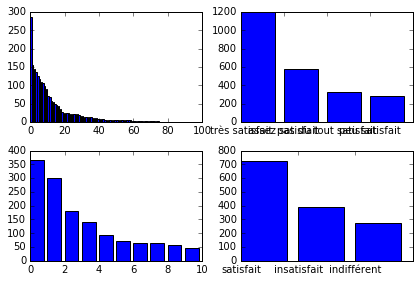

In [2]:

fig, ax = plt.subplots(nrows=2, ncols=2)
#fig.set_figwidth(100)
#fig.set_figheight(50)
fig.tight_layout()

# Data1
target_columns = {'sentiments':'3 - Satisfaction contact conseiller','categories':'Motif appel'}
data1_data = load_data_xls('Compil Verbatims clients.xlsx','data1','Feuil1','Verbatims', target_columns, 
                         'indifférent', ax= ax[0], show_hist=True)

# Oranged
target_columns = {'sentiments':"Q4_4 - Qualité de la solution proposée",'categories':"Q1 - Motif principal d’appel"}
oranged_data = load_data_xls('100pc_Open_ACH_2014 06.xlsx','oranged','Open Juin',"QO6 - Verbatim sur l'appel", target_columns, 
                            'indifférent', ax= ax[1],show_hist=True)

# Toys
toys_data = load_xls_from_folder('C:/Users/MACH055/Documents/Data/Toys/','toys','Feuil1',"q8", target_columns=[],
                                 default_sentiment=None, ax= None,show_hist=False)

In [35]:
def count_length(verbatim):
    ver = remove_patterns(str(verbatim))
    tokens = word_tokenizer.tokenize(ver)
    return (len(tokens))

lengths = toys_data["verbatims"].apply(count_length)

In [37]:
np.mean(lengths)

17.15087320450553

In [3]:
data1_data.ix[data1_data["sentiments"]=='très satisfait',"sentiments"] = 'satisfait'
data1_data.ix[data1_data["sentiments"]=='pas du tout satisfait',"sentiments"] = 'insatisfait'

In [4]:
data1_data.ix[data1_data["sentiments"]=='assez satisfait',"sentiments"] = 'satisfait'
data1_data.ix[data1_data["sentiments"]=='peu satisfait',"sentiments"] = 'insatisfait'

In [5]:
data= pandas.concat([data1_data,oranged_data])
data = data.reset_index(drop=True)

In [6]:
# "sources" est une liste de valeurs des données sur lesquelles on va travailler
# "target" prend 2 valeurs : "sentiments" ou "categories"
def extract_verbatimsandtarget(data,sources , target="sentiments"):
    verbatims = data["verbatims"][data["src"].isin(sources)]
    
    y=None
    # Rendre le vecteur resultat de type "categorielle" 
    if target != "" :
        y = data[target][data["src"].isin(sources)]
        y = y.astype("category", categories=np.unique(y), ordered=False)
    return verbatims, y

target = "sentiments"
verbatims, y = extract_verbatimsandtarget(data,["data1","oranged"],target)

verbatims_data1, y_data1 = extract_verbatimsandtarget(data,["data1"],target)

verbatims_oranged, y_oranged = extract_verbatimsandtarget(data,["oranged"],target)

verbatims_toys, y_toys = extract_verbatimsandtarget(toys_data,["toys"],"")

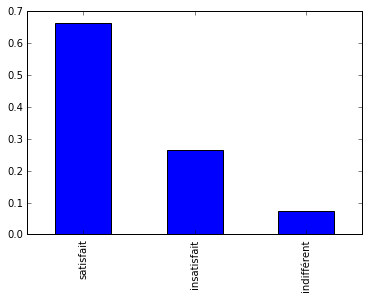

In [7]:
(y.value_counts() / len(y)).plot(kind="bar")

Isoler les smileys et les hashtags

In [8]:
groups_to_keep =[r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)",# hash-tags
                r"""
    (?:
      [<>]?
      [:;=]                     # eyes
      [\-o\*\']?                 # optional nose
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth      
      |
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      [\-o\*\']?                 # optional nose
      [:;=]                     # eyes
      [<>]?
    )""" #smileys
                ]

regex_to_keep=  r'('+'|'.join(groups_to_keep)+')'

In [9]:
verbatims_extra = verbatims.map(lambda verbatim: re.findall(regex_to_keep,str(verbatim)))

In [10]:
verbatims_extra[pandas.isnull(verbatims_extra)]

Series([], Name: verbatims, dtype: object)

## ----------------------------------- Regroupement des motifs Data1 ----------------------------------------

Isolation des motifs d'appel

In [2]:
motifs_appels_macro = y_cat_data1.copy(deep=True)
motifs, nombre_motifs = np.unique(y_cat_data1,return_counts=True)
sorted_motifs = motifs[np.argsort(-nombre_motifs)]

Chargement du fichier regroupant les motifs d'appels macro

In [3]:
xls_themes=pandas.ExcelFile(path+"Motifs d'appels.xlsx")
# Feuille n°1
themes_data1_1=xls_themes.parse('Demande')
# Feuille n°2
themes_data1_2=xls_themes.parse('Reclamation')

In [4]:
themes_data1_1=themes_edf_1[pandas.notnull(themes_data1_1['Désignation'])]
themes_data1_2=themes_edf_2[pandas.notnull(themes_data1_2['Désignation'])]

# Regroupement des 2 feuilles Excel en un seul dataframe
themes_data1 = pandas.concat([themes_data1_1,themes_data1_2],ignore_index=True)

Logique floue avec un seuil de confiance de 90%

Les motifs non reconnus (sous 90%) sont classés dans la catégorie "Autres"

In [5]:
mapping_motifs = pandas.DataFrame(np.transpose([motifs,motifs]),columns=['micro_src','micro_dest'])
seuil_confiance = 90

def fuzzy_logic(motif):
    resultat = process.extractOne(motif, themes_data1["Désignation"])
    if resultat[1] > seuil_confiance :
        return resultat[0]
    else : 
        return np.nan

def get_macro_category(micro):
    if not pandas.isnull(micro) :
        return themes_data1["Thème/Motif"][themes_data1["Désignation"]== micro].values[0]
    else:
        return 'Autres'
    
mapping_motifs['micro_dest'] = mapping_motifs['micro_dest'].map(fuzzy_logic)
mapping_motifs['macro'] =  mapping_motifs['micro_dest'].copy(deep=True)

mapping_motifs['macro'] = mapping_motifs['macro'].map(get_macro_category)

Formattage des étiquettes macro 

In [6]:
y=motifs_appels_macro.map(lambda x:mapping_motifs['macro'][mapping_motifs['micro_src']==x].values[0] )

(array([ 4.,  1.,  2.,  1.,  0.,  1.,  1.,  0.,  1.,  1.]),
 array([  10. ,   63.9,  117.8,  171.7,  225.6,  279.5,  333.4,  387.3,
         441.2,  495.1,  549. ]),
 <a list of 10 Patch objects>)

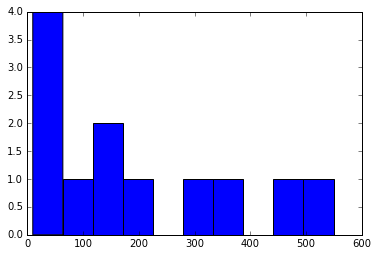

In [261]:
a,b= np.unique(y,return_counts=True)
plt.hist(b)

## ========================================================================

## Sélection des motifs d'appels les plus représentés

pourcentage de motifs gardés : 80.6282722513


(array([ 5.,  4.,  3.,  2.,  2.,  1.,  2.,  1.,  0.,  1.]),
 array([ 1.07329843,  1.95026178,  2.82722513,  3.70418848,  4.58115183,
         5.45811518,  6.33507853,  7.21204188,  8.08900524,  8.96596859,
         9.84293194]),
 <a list of 10 Patch objects>)

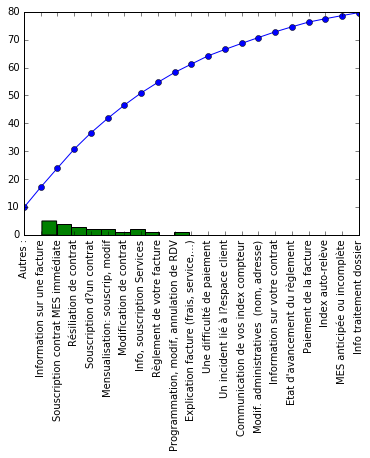

In [327]:
nb_motifs_a_garder = 21

percentage_categories = 100*np.cumsum(-np.sort(-nombre_motifs))/np.sum(nombre_motifs)
percentage_categories_nocumsum = 100*(-np.sort(-nombre_motifs))/np.sum(nombre_motifs)
plt.plot(percentage_categories[:nb_motifs_a_garder],'-o')
plt.xticks(range(0,nb_motifs_a_garder),sorted_motifs[:nb_motifs_a_garder],rotation='vertical')
print("pourcentage de motifs gardés :",percentage_categories[nb_motifs_a_garder])
plt.hist(percentage_categories_nocumsum[:nb_motifs_a_garder])

Sélection des observations dont les motifs seront gardés

In [4]:
verbatims_data1_filtered = verbatims_data1[motifs_appels.isin(sorted_motifs[:nb_motifs_a_garder])]
motifs_appels_filtered = motifs_appels[motifs_appels.isin(sorted_motifs[:nb_motifs_a_garder])]

# Copie dans une autre Series afin d'avoir de bons indexs
verbatims_data1_final = pandas.Series(verbatims_data1_filtered,index=range(len(verbatims_data1_filtered)))
motifs_appels_filtered = pandas.Series(motifs_appels_filtered,index=range(len(motifs_appels_filtered)))

# ==============================================================

## Pre-processing du texte

Initialisation des outils pour le pre-processing

In [11]:
def remove_patterns(verbatim) :
    if re.search(regex_to_delete, verbatim) :
        return re.sub(regex_to_delete, "", verbatim) 
    return verbatim

def no_accents(s):
    s= unicodedata.normalize('NFD',s)
    return str(s.encode('ascii','ignore'), 'utf-8')

groups_to_delete = [r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
                    r'(?:(?:\d+,?)+(?:\.?\d+)?)',# numbers
                    r'([_\-]+)' # underscores and dashes
    ] 

                 
regex_to_delete = r'('+'|'.join(groups_to_delete)+')'

word_tokenizer = RegexpTokenizer('\w+', gaps=False)

frenchStemmer= SnowballStemmer('french', ignore_stopwords=True)

stop_words_french = stopwords.words('french')
stop_words_french_normalized =[no_accents(stop) for stop in stop_words_french]

JAR_PATH = 'C:/Users/MACH055/Documents/code/stanford-postagger-full-2015-12-09/stanford-postagger.jar'
French_MODEL_PATH = 'C:/Users/MACH055/Documents/code/stanford-postagger-full-2015-12-09/models/french.tagger'
FrenchPostagger = StanfordPOSTagger(French_MODEL_PATH, JAR_PATH, encoding='utf8')

french_tagger = treetaggerwrapper.TreeTagger(TAGLANG='fr')

L'étape de preprocessing des verbatims comprend :
* suppression des chiffres, balises html, émoticones et adresses URL
* suppression des accents
* suppression des stop words et des mots ne dépassant pas les 2 caractères
* stemming

In [12]:
def preprocess_data(data, cleaning=True, stemming=True, pos_tagging_lemmatization=False):
    clean_verbatims = list()
    pos_tagged = list()
    
    # POS-Tagging
    #if pos_tagging :
     #   sentences = [str(v).split() for v in data]
    #  pos_tagged = FrenchPostagger.tag_sents(sentences)
       
    
    for verbatim in data :
        
        # remove numbers, html ...
        if cleaning :
            verbatim_i = remove_patterns(str(verbatim))
        
        # POS-Tagging
        if pos_tagging_lemmatization :
            temp_pos = french_tagger.tag_text(verbatim_i)
            tags = treetaggerwrapper.make_tags(temp_pos)
            pos_tagged.append(tags)
            
            # Fonction permettant d'obtenir le lemme d'un objet Tag ou recuperer le mot si un objet NotTag
            getlemma_pos = lambda x : operator.attrgetter('lemma')(x) if (
                isinstance(x,treetaggerwrapper.Tag)) else operator.attrgetter('what')(x)
            verbatim_i = ' '.join([getlemma_pos(tag) for tag in tags])
            
        # remove accents 
        tokens = word_tokenizer.tokenize(no_accents(verbatim_i))
            
        # remove stop words + to lower case + stemming
        if stemming :
            tokens_w_s = [frenchStemmer.stem(i.lower()) for i in tokens if (i not in stop_words_french_normalized) & (len(i)>2)]
            
        if pos_tagging_lemmatization :
            tokens_w_s = [i for i in tokens if (i not in stop_words_french_normalized) & (len(i)>2)]
            
        # concat words
        clean_verbatims.append(' '.join(tokens_w_s))
        
    return clean_verbatims, pos_tagged

### Sentiment scoring

Chargement du dictionnaire de correpondance Français - Princeton Wordnet

In [13]:
PATH_WN = "C:/Users/MACH055/Documents/code/"

def split_wn_code(wn_code):
    return wn_code.split('-')

converters = {"wn_code":split_wn_code}

wn_fr_data = pandas.read_csv(PATH_WN+'wn-data-fra.tab',sep='\t',usecols=[0,2,3],names=['wn_code','word','POS'],skiprows=1,converters=converters)

wn_code = wn_fr_data['wn_code'].map(lambda x : operator.itemgetter(0)(x))
pos = wn_fr_data['wn_code'].map(lambda x : operator.itemgetter(1)(x))
wn_fr_data['wn_code'] = wn_code
wn_fr_data['POS'] = pos

Chargement du dictionnaire Sentiwordnet 

In [14]:
types = {'POS':object,'wn_code':object,'pos_score':float,'neg_score':float}
senti_data = pandas.read_csv(PATH_WN+'SentiWordNet_3.0.0_20130122.txt',sep='\t',usecols=[0,1,2,3],names=['POS','wn_code','pos_score','neg_score'],
                             comment='#',skiprows=1, dtype=types)

Jointure entre WOLF et SentiWordNet par le code wordnet

In [15]:
sentiments_fr = pandas.merge(wn_fr_data, senti_data, how='inner',on=['POS','wn_code'])

In [16]:
sentiments_fr[sentiments_fr["word"] == "attention"]

,wn_code,word,POS,pos_score,neg_score
2849,00129527,attention,n,0.000,0.000
11164,00654885,attention,n,0.000,0.000
19631,01228645,attention,n,0.250,0.000
54030,05082790,attention,n,0.000,0.000
56380,05650579,attention,n,0.000,0.125
56649,05702275,attention,n,0.000,0.000
56650,05702726,attention,n,0.000,0.000
56657,05704096,attention,n,0.125,0.000
57439,05853636,attention,n,0.000,0.000


Calcul de la positivité et de la négativité pour une phrase en sommant la positivité et la négativité moyenne de chaque terme composant la phrase

In [17]:
# conditions : liste de tuples (lemme, POS)
def extract_mean_pos_neg(conditions_sent):
    mean_pos_sent, mean_neg_sent = 0, 0
    if len(conditions_sent)>0 :
        getword = operator.itemgetter(0)
        words = list(map(getword,conditions_sent))
        sentiments_filtered = sentiments_fr[sentiments_fr["word"].isin(words)]
        for condition in conditions_sent :
            result = sentiments_filtered [(sentiments_filtered ["word"] == condition[0]) & 
                                          (sentiments_filtered["POS"] == condition[1])]
            
            result_size = result.shape[0]
            if result_size >0 :
                mean_pos_sent = mean_pos_sent + (np.sum(result["pos_score"]))/result_size 
                mean_neg_sent = mean_neg_sent + (np.sum(result["neg_score"]))/result_size 
            
    return mean_pos_sent, mean_neg_sent

### ====> Pre-processing (Data1) <=====

In [18]:
preprocessed_data_data1, pos_tagged_data1 = preprocess_data(verbatims_data1, cleaning=True, stemming=True, pos_tagging_lemmatization=False)

### ====> Pre-processing (Oranged) <=====

In [19]:
preprocessed_data_oranged, pos_tagged_oranged = preprocess_data(verbatims_oranged, cleaning=True, stemming=True, pos_tagging_lemmatization=False)

### ====> Pre-processing (Oranged, Data1) <=====

In [20]:
preprocessed_data, pos_tagged = preprocess_data(verbatims, cleaning=True, stemming=True, pos_tagging_lemmatization=True)

Calcul de la positivité et de la négativité de tous les verbatims 

In [98]:
def compute_pos_neg(pos_tagged):

    mean_pos = list()
    mean_neg = list()
    getlemma_pos = lambda x : (operator.attrgetter('lemma')(x),str(operator.attrgetter('pos')(x)).lower()[0]) if (isinstance(x,treetaggerwrapper.Tag)) else ('','')    

    for sent in pos_tagged :
        conditions = list(map(getlemma_pos,sent))
        mean_pos_i , mean_neg_i = extract_mean_pos_neg(conditions)

        mean_pos.append(mean_pos_i)
        mean_neg.append(mean_neg_i)

    mean_pos = pandas.DataFrame(mean_pos)
    mean_neg = pandas.DataFrame(mean_neg)
    
    return mean_pos, mean_neg

###  ====> Pre-processing (Toys) <=====

In [22]:
preprocessed_data_toys, pos_tagged_toys = preprocess_data(toys_data['verbatims'], stemming=False, pos_tagging_lemmatization=True)

## =========================================================================

### Enlever les bigrammes lorsque les trigrammes existent

In [22]:
def delete_bigram(bigram,trigram,list_bigrams):
    return (bigram in list_bigrams)

def remove_bigram_when_trigram(feature_names):
    feature_names_reduced= list(feature_names)
    number_of_words = {name :len(name.split()) for name in feature_names_reduced }

    #Indexation des n-grams par son premier caractère et stockage dans un dictionnaire
    dictionary= {char: list() for char in al}
    for name in feature_names_reduced :
        if(number_of_words[name]==2):
            dictionary[name[0]].append(name) 

    for ngram in number_of_words:
        if(number_of_words[ngram] == 3):
            words = ngram.split()
            firstchar_1 = words[0][0]
            firstchar_2 = words[1][0]
            bigram_left = words[0]+" "+words[1]
            bigram_right = words[1]+" "+words[2]

            # Verifier si le premier bigramme est present dans la liste des features, si oui le retirer 
            if(delete_bigram(bigram_left,ngram,dictionary[firstchar_1])) :
                try:
                    feature_names_reduced.remove(bigram_left)
                except ValueError:
                    pass  

            # Verifier si le deuxieme bigramme est present dans la liste des features, si oui le retirer
            if(delete_bigram(bigram_right,ngram,dictionary[firstchar_2])):
                try:
                    feature_names_reduced.remove(bigram_right)
                except ValueError:
                    pass  
    return feature_names_reduced
    # Récupération des indices des colonnes correspondant aux features sélectionnées
    #feature_indexes = [tf.vocabulary_[feature] for feature in feature_names_reduced]   
    
    #return feature_indexes

# =============================================================

## Application du modèle

### Définition des fonctions utilitaires

In [97]:
# Le parametre "scoring" peut prendre une des valeurs de cette liste : 

# ['accuracy', 'adjusted_rand_score', 'average_precision', 'f1', 'f1_macro',
#'f1_micro', 'f1_samples', 'f1_weighted', 'log_loss', 'mean_absolute_error', 'mean_squared_error', 'median_absolute_error',
#'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro',
#'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc']

def classify(classifier,preprocessed_data, y, params,with_grid_search,folds= 5,scoring='f1_weighted'):
    
    # Constitution des ensembles de training, validation et test
    preprocessed_data_train, preprocessed_data_test, y_train, y_test = train_test_split(preprocessed_data,y,test_size=0.3)
  
    print("****** Training *******")
    print("Classifieur utilisé : ",parse_classifier(classifier))
        
    # AVEC GridSearch
    if with_grid_search : 
        grid_search = GridSearchCV(classifier, param_grid=params, cv= folds, scoring = scoring)
        grid_search.fit(preprocessed_data_train,list(y_train))
        y_hat = grid_search.predict(preprocessed_data_test)
        
        
        print("Best score: %0.3f" % grid_search.best_score_)
        print("Best parameters set:")
        best_parameters = grid_search.best_estimator_.get_params()
        for param_name in sorted(params.keys()):
            print("\t%s: %r" % (param_name, best_parameters[param_name])) 
    
    # SANS GridSearch
    else :
        y_hat = cross_val_predict(classifier,preprocessed_data,y,cv=folds)
        y_test = y
        
    compute_scores_test(y_test,y_hat,y)
        
def compute_scores_test(y_test,y_hat,y):
    print("\n ******* Test *******")
    result = pandas.DataFrame()
    score_misclassification = zero_one_loss(y_test,y_hat,normalize=True)
    print("Précision 0/1 loss:" ,1 - score_misclassification)
    print("Précision F1:" , f1_score(y_test,y_hat,average='weighted',labels=np.unique(y)))
    print("Hasard : ", 1/len(np.unique(y)))
    
def parse_classifier(classifier):
    if  isinstance(classifier,Pipeline) : 
        return list(map(operator.itemgetter(1),classifier.steps))
    else :
        return classifier

### Applications et tuning

TF-IDF + Select K-Best + Naive Bayes (Gridsearch)

In [32]:
ml_pipeline = Pipeline([
        ('vectorization',TfidfVectorizer(analyzer='word', min_df = 0)),
  ('feature_selection', SelectPercentile(percentile=90)),
  ('classification', MultinomialNB())
])

params = dict(vectorization__ngram_range=[(1,1),(1,2),(1,3)],vectorization__sublinear_tf=[True,False],
              feature_selection__score_func =[chi2,f_classif],feature_selection__percentile=[70,80,90,95,100],
              classification__alpha=[.01,.05,.1,.2,.5,1,5])

## Sentiments

### Oranged  ==> Sentiments

In [89]:
classify(ml_pipeline,preprocessed_data_oranged, y_oranged, params,with_grid_search=True,folds= 5, scoring='accuracy')

****** Training *******
Classifieur utilisé :  [TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None), SelectPercentile(percentile=90,
         score_func=<function f_classif at 0x00000000099E4510>), MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)]
Best score: 0.619
Best parameters set:
	classification__alpha: 0.2
	feature_selection__percentile: 90
	feature_selection__score_func: <function f_classif at 0x00000000099E4510>
	vectorization__ngram_range: (1, 1)
	vectorization__sublinear_tf: True

 ******* Test *******
Précision 0/1 loss: 0.635491606715
Précision F1: 0.57602679436
Hasard :  0.333

### Data1  ==> Sentiments

In [90]:
classify(ml_pipeline,preprocessed_data_data1, y_data1, params,with_grid_search=True,folds= 5, scoring='accuracy')

****** Training *******
Classifieur utilisé :  [TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None), SelectPercentile(percentile=90,
         score_func=<function f_classif at 0x00000000099E4510>), MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)]
Best score: 0.757
Best parameters set:
	classification__alpha: 0.2
	feature_selection__percentile: 100
	feature_selection__score_func: <function chi2 at 0x00000000099E4620>
	vectorization__ngram_range: (1, 1)
	vectorization__sublinear_tf: False

 ******* Test *******
Précision 0/1 loss: 0.744769874477
Précision F1: 0.706897559608
Hasard :  0.33333

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Oranged, Data1  ==> Sentiments

In [91]:
classify(ml_pipeline,preprocessed_data, y, params,with_grid_search=True,folds= 5, scoring='accuracy')

****** Training *******
Classifieur utilisé :  [TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None), SelectPercentile(percentile=90,
         score_func=<function f_classif at 0x00000000099E4510>), MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)]
Best score: 0.693
Best parameters set:
	classification__alpha: 0.1
	feature_selection__percentile: 100
	feature_selection__score_func: <function chi2 at 0x00000000099E4620>
	vectorization__ngram_range: (1, 1)
	vectorization__sublinear_tf: False

 ******* Test *******
Précision 0/1 loss: 0.710758377425
Précision F1: 0.660053227877
Hasard :  0.33333

## Utilisation de la moyenne de sentiments 

In [100]:
mean_pos, mean_neg = compute_pos_neg(pos_tagged)
sentiments_num_hat = np.sign(mean_pos - mean_neg)

In [119]:
def translate_to_sentiments(y):
    target = pandas.Series(list(y))
    target[target == 'satisfait'] = 1
    target[target == 'insatisfait'] = -1
    target[target == 'indifférent'] = 0
    return target

sentiments_num = translate_to_sentiments(y)

In [122]:
np.sum(sentiments_hat[0]== sentiments_num)/len(y)

0.5387873974053482

## =================================
## Utilisation de la moyenne de sentiments + Multinomial N.B.

In [389]:
ml_pipeline = Pipeline([
        ('vectorization',TfidfVectorizer(analyzer='word', min_df = 0,ngram_range=(1,3),sublinear_tf=True)),
  ('feature_selection', SelectKBest(score_func=chi2,k=10000))])

                       
X_new = ml_pipeline.fit_transform(preprocessed_data,y.cat.codes)


In [390]:
classifier = MultinomialNB()
y_hat = cross_val_predict(classifier,X_new,y.cat.codes)
score_misclassification = zero_one_loss(y.cat.codes,y_hat,normalize=True)

In [391]:
1 - score_misclassification

0.66216574000529516

In [392]:
y_hat = pandas.Series(y_hat)

In [395]:
X_new_2 = pandas.concat([y_hat,pandas.DataFrame(mean_pos) , pandas.DataFrame(mean_neg)], axis=1)
#X_new_2 = pandas.concat([pandas.DataFrame(mean_pos) , pandas.DataFrame(mean_neg)], axis=1)

In [396]:
classifier2 = LogisticRegression()
y_hat_2 = cross_val_predict(classifier2,X_new_2,y.cat.codes)
score_misclassification = zero_one_loss(y.cat.codes,y_hat_2,normalize=True)

In [397]:
print(1- score_misclassification)

0.676462801165


## ================================================

## Categorisation du contenu

In [92]:
verbatims_data1, y_data1_cat = extract_verbatimsandtarget(data,["data1"],"categories")
verbatims_oranged, y_oranged_cat = extract_verbatimsandtarget(data,["oranged"],"categories")

## Data1 ==> Categorisation

In [126]:
len(np.unique(y_data1_cat))

98

In [1]:
classify(ml_pipeline,preprocessed_data_data1, y_data1_cat, params,with_grid_search=True,folds= 5)

NameError: name 'classify' is not defined

## Orange ==> Categorisation

In [2]:
classify(ml_pipeline,preprocessed_data_oranged, y_oranged_cat, params,with_grid_search=True,folds= 5)

NameError: name 'classify' is not defined

# Tuning 

In [352]:
print(metrics.classification_report(y_test, y_hat))

             precision    recall  f1-score   support

    ACCUEIL       0.00      0.00      0.00        46
     Autres       0.28      0.27      0.28       151
CONSEIL ET SERVICE       0.00      0.00      0.00        51
    CONTRAT       0.00      0.00      0.00        11
FACTURATION       0.26      0.77      0.39       180
MODIFICATION CONTRAT FOURNITURE       0.23      0.06      0.09        87
QUALITE DE FOURNITURE & RESEAUX       0.00      0.00      0.00         6
RECOUVREMENT       0.00      0.00      0.00         4
RELATIONS AVEC LE DISTRIBUTEUR       0.00      0.00      0.00        33
     RELEVE       0.00      0.00      0.00         1
RESILIATION CONTRAT FOURNITURE       0.00      0.00      0.00        56
SOUSCRIPTION CONTRAT FOURNITURE       0.12      0.02      0.04        91

avg / total       0.17      0.26      0.17       717



C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [18]:
class SelectTrigram(SelectKBest):  

    def __init__(self,feature_names,k='all'):
        super(SelectTrigram, self).__init__( score_func=chi2,k=k)
        self.feature_names = feature_names
        
    def transform(self, X):
        X_r = super().transform(X)
        feature_names_1 = [self.feature_names[i] for i in self.get_support(indices=True)]
        idx = remove_bigram_when_trigram(feature_names_1)
        return X[:,idx]

In [25]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,3), min_df = 0)

tfidf_matrix_train =  tf.fit_transform(preprocessed_data_oranged)
feature_names = tf.get_feature_names() 

In [627]:
ml_pipeline_2 = Pipeline([
  ('feature_selection', SelectTrigram(feature_names, k=10000)),
  ('classification', MultinomialNB(alpha=.01))
])

## Doc2Vec

In [49]:
sentences = []
for item_no, line in enumerate(preprocessed_data):
    sentences.append(LabeledSentence(line.split(), ['test'+str(item_no)]))

In [50]:
# hs : hierarchichal sampling hs=1
# negative : negative sampling (negative = 5)
model = Doc2Vec(min_count=5, window=15,  sample=1e-4,workers=8, hs=1)
model.build_vocab(sentences)

In [51]:
#for epoch in range(10):
model.train(sentences)

78539

In [31]:
model.save('./vectorized.d2v')

In [32]:
model.load('./vectorized.d2v')

In [52]:
docvec = pandas.DataFrame(model.docvecs.doctag_syn0)


In [40]:
classifier = LogisticRegression()
docvec_train, docvec_test, y_train, y_test = train_test_split(docvec,y,test_size=0.3)
classifier.fit(docvec_train,y_train)
y_hat_test = classifier.predict(docvec_test)
score_misclassification = zero_one_loss(y_test,y_hat_test,normalize=True)

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 4

In [143]:
score_misclassification

0.34479717813051147

# =============================================================

# Topic Modeling

In [21]:
def guess_topic_from_top_words(topic_modeller, feature_names, n_top_words,num_topics,X,verbatims,num_verbatims):
    print("H",topic_modeller.components_.shape)
    topics = {}
    topic_features=[]
    
    for topic_idx, topic in enumerate(topic_modeller.components_):
        print("Topic #%d:" % topic_idx)
        features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_features.append(features)
        print(",".join(features))
        
        verbatim_topic = X[:,topic_idx].argsort()
        print(verbatims.iloc[verbatim_topic[:-num_verbatims-1:-1]])
        intitule = input("Entrez l'intitulé du topic n°"+str(topic_idx)+ ": ")
        topics.update({topic_idx : intitule})
    compute_coherence_scores(num_topics,topic_features)
    return topics

def compute_coherence_scores(num_topics, topic_features):
    combins = list(combinations(range(num_topics),2))
    print(combins)
    jaccard_sim = [jaccard_similarity_score(topic_features[combination[0]], topic_features[combination[1]], normalize=False
                                           ) for combination in combins]
    print(jaccard_sim)
    return jaccard_sim
    
def draw_verbatims_per_topics(verbatims_topics,title,ax):
    ax.set_aspect('auto')
    graph=pandas.Series(verbatims_topics).value_counts().plot(kind='bar',color=['b','r','g','y','maroon'],title=title,ax=ax)
    graph.axes.set_ylabel('Nombre de verbatims')

def extract_topics(chain, preprocessed_data,num_topics, num_top_words,verbatims,num_verbatims):
    X = preprocessed_data
    X = chain['vectorizer'].fit_transform(X)
    X = chain['decomposition_model'].fit_transform(X)

    print("W",X.shape)
    
        
    # X is the matrix W in : A = W*H (W is a matrix (n_documents, n_topics)), H is in the attribute components_
    topics = guess_topic_from_top_words(chain['decomposition_model'],
                                          chain['vectorizer'].get_feature_names(),num_top_words,num_topics,X,verbatims,num_verbatims)
    verbatim_topic = [topics[x] for x in X.argmax(axis=1)]
    return topics, verbatim_topic

def extract_topics_by_sentiment(chain, preprocessed_data, y,num_topics, num_top_words,ax,verbatims,num_verbatims):
    d = {'preprocessed_data': preprocessed_data, 'y': y}
    #d = {'preprocessed_data': preprocessed_data}
    data = pandas.DataFrame(data=d)
    i=0
    #for sentiment in np.unique(y):
    #    topics, verbatim_topic= extract_topics(chain, data[data["y"] == sentiment]["preprocessed_data"],
    #                                           num_topics, num_top_words,verbatims[data["y"] == sentiment])
    #    draw_verbatims_per_topics(verbatim_topic,sentiment,ax[i])
    #    i += 1
    topics, verbatim_topic= extract_topics(chain, data["preprocessed_data"], num_topics, num_top_words,verbatims,num_verbatims)
    draw_verbatims_per_topics(verbatim_topic,'tout',ax.flatten()[i])
    

1) TF-IDF + NMF (Non-Negative Matrix Factorization)

W (3777, 5)
H (5, 25885)
Topic #0:
suivre satisfaire,satisfaire reponse,satisfaire ajouter,satisfaire instant,special suivre,satisfaire contact,reponse edf,contact conseiller,satisfaire demande,requete suivre
376        \n   rien je suis satisfait.
784                  je suis satisfaite
1730    rien de plus je suis satisfaite
2952                 je suis satisfaite
681                  je suis satisfaite
Name: verbatims, dtype: object
Entrez l'intitulé du topic n°0: satisfaction
Topic #1:
temps attente,reduire temps,attente conseiller,attente long,attente telephone,diminuer temps,attente joindre,attente minute,joindre conseiller,obtenir conseiller
1913              le temps d'attente
2118         trop de temps d'attente
2013                 Temps d'attente
693          Trop de temps d'attente
2213    Réduire le temps d'attente ?
Name: verbatims, dtype: object
Entrez l'intitulé du topic n°1: attente
Topic #2:
rapide efficace,service rapide,clair rapide,conseiller rapide,efficace parfai

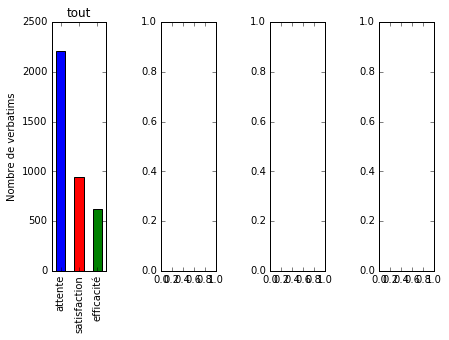

In [156]:
num_topics = 5
num_top_words = 10
num_verbatims = 5
fig, ax = plt.subplots(nrows=1, ncols=4)
fig.tight_layout() 
plt.subplots_adjust(wspace=1)

chain = {"vectorizer" : TfidfVectorizer(analyzer='word', ngram_range=(2,2),sublinear_tf=True, min_df = 0),
  "decomposition_model" : NMF(n_components=num_topics, init='nndsvd', random_state=1)}

extract_topics_by_sentiment(chain,preprocessed_data,y,num_topics,num_top_words,ax,verbatims,num_verbatims)

2) TF-IDF + LDA (Latent Dirichlet Allocation)

In [113]:
lda = LatentDirichletAllocation(n_topics=num_topics, 
                                learning_method='batch', learning_offset=50.,
                                random_state=0)
chain = {"vectorizer" : TfidfVectorizer(analyzer='word', ngram_range=(1,3),sublinear_tf=True, min_df = 0),
  "decomposition_model" : lda}

extract_topics_by_sentiment(chain,preprocessed_data_toys,y,num_topics,num_top_words,ax,verbatims_toys)

W (48385, 5)
H (5, 43283)
Topic #0:
caisse,attente,attente caisse,personnel,prix,produit,desagreable,magasin,personnel desagreable,jouet
1536    LA DIRECTION EST DE MAUVAISE FOI SUITE A UN PR...
1559    LA DIRECTION EST DE MAUVAISE FOI SUITE A UN PR...
1536    LA DIRECTION EST DE MAUVAISE FOI SUITE A UN PR...
1536    LA DIRECTION EST DE MAUVAISE FOI SUITE A UN PR...
1536    LA DIRECTION EST DE MAUVAISE FOI SUITE A UN PR...
Name: verbatims, dtype: object
Entrez l'intitulé du topic n°0: a
Topic #1:
magasin,prix,produit,caisse,achat,mauvais,personnel,vendeur,enseigne,attente
1350    pas de stock et trop d attente en caisse.1er a...
1258    pas de stock et trop d attente en caisse.1er a...
1258    pas de stock et trop d attente en caisse.1er a...
1258    pas de stock et trop d attente en caisse.1er a...
1258    pas de stock et trop d attente en caisse.1er a...
Name: verbatims, dtype: object
Entrez l'intitulé du topic n°1: a


KeyboardInterrupt: 

3) TF-IDF + PCA (TruncatedSVD)

In [166]:
pca =TruncatedSVD(n_components=10)

vectorizers = [TfidfVectorizer(analyzer='word', ngram_range=(1,3),sublinear_tf=True, min_df = 0,use_idf=True),
  pca]
extract_topics(vectorizers,preprocessed_data_toys,num_topics,num_top_words)
print(pca.explained_variance_ratio_)

Topic #0:
trop,prix,trop attent,trop loin,loin,attent,attent caiss,trop attent caiss,caiss,elev
Topic #1:
prix,prix elev,elev,les prix,les,magasin,les prix elev,rapport,ailleur,elev rapport
Topic #2:
caiss,attent,attent caiss,trop attent,personnel,trop attent caiss,desagre,magasin,produit,longu
Topic #3:
prix,magasin,produit,prix ailleur,ailleur,desagre,accueil,les,les prix,prix magasin
Topic #4:
desagre,personnel,magasin,personnel desagre,accueil,produit,accueil desagre,pas,elev,prix elev
Topic #5:
desagre,personnel,personnel desagre,accueil,prix,accueil desagre,caissier desagre,attent caiss,caissier,attent
Topic #6:
loin,magasin,trop loin,loin domicil,domicil,trop loin domicil,magasin loin,jouet,magasin agreabl,rapport magasin
Topic #7:
choix,loin,pas,trop loin,pas choix,loin domicil,domicil,trop loin domicil,choix prix,pas agreabl
Topic #8:
produit,loin,ailleur,les,trop loin,les produit,desagre,les prix,trouv,trouv produit
Topic #9:
accueil,mauv accueil,mauv,accueil desagre,decu,per

## Topic Modeling : Utilisant Word2Vec (Clustering short texts)

In [42]:
data_enlisted = list()
for verbatim in preprocessed_data_toys:
    data_enlisted.append(str(verbatim).split())

In [43]:
import itertools 
len(np.unique(list(itertools.chain(*data_enlisted))))

4128

In [120]:
len(data_enlisted)

48385

In [44]:
# hs : hierarchichal sampling hs=1
# negative : negative sampling (negative = 5)
model = Word2Vec(min_count=1, window=3,  sample=1e-4,workers=8, sg=0, negative=5)
model.build_vocab(data_enlisted)

In [45]:
#for epoch in range(10):
model.train(data_enlisted)

775223

In [26]:
model.most_similar('attente')

[('caisse', 0.9983683228492737),
 ('longue', 0.9979857206344604),
 ('ouvrir', 0.9978874921798706),
 ('interminable', 0.9977173805236816),
 ('ouvert', 0.9976296424865723),
 ('long', 0.9969397783279419),
 ('seul', 0.9969266057014465),
 ('queue', 0.9967086315155029),
 ('personnel', 0.9964598417282104),
 ('temps', 0.9964555501937866)]

In [127]:
docvec = pandas.DataFrame(model.syn0)


In [103]:
pandas.DataFrame(model.s).iloc[1,:].sort_values()

AttributeError: 'Word2Vec' object has no attribute 'syn1norm'

In [116]:
model.index2word[60]

'text'

In [98]:
docvec.iloc[1,:].sort_values()

62   -0.272447
27   -0.227708
90   -0.219479
46   -0.204137
25   -0.193280
33   -0.192067
3    -0.183295
36   -0.180912
51   -0.179840
2    -0.170874
89   -0.167094
76   -0.154824
7    -0.129253
5    -0.119520
41   -0.113542
38   -0.112234
65   -0.104136
4    -0.100975
85   -0.095591
35   -0.086529
23   -0.084725
44   -0.084581
21   -0.082150
69   -0.081649
49   -0.077464
71   -0.075470
63   -0.070054
37   -0.067074
32   -0.062574
48   -0.058179
        ...   
9     0.060226
8     0.066306
39    0.072970
73    0.080188
6     0.080338
0     0.081068
20    0.083765
84    0.090938
10    0.096742
93    0.098390
24    0.099080
95    0.101921
1     0.104841
42    0.108646
81    0.110456
87    0.112593
79    0.123598
12    0.126274
57    0.136953
78    0.143556
19    0.144581
67    0.149826
97    0.160861
31    0.164573
82    0.166587
55    0.182832
72    0.187106
80    0.189574
66    0.199015
60    0.249484
Name: 1, dtype: float32

In [93]:
docvec_1 = pandas.DataFrame(model.syn1)
docvec_1.shape

(4995, 100)

In [53]:
model_gmm = VBGMM(n_components=5,alpha=1)
y = model_gmm.fit_predict(np.transpose(docvec))


In [103]:
model_gmm.precs_

[array([[  1.12498642e+03,  -1.83688875e-04,  -1.72574568e-04, ...,
          -1.99015423e-04,  -1.52113430e-04,  -1.83207766e-04],
        [ -1.83688875e-04,   1.12498642e+03,  -1.73192264e-04, ...,
          -1.99613960e-04,  -1.52862780e-04,  -1.84610692e-04],
        [ -1.72574568e-04,  -1.73192264e-04,   1.12498644e+03, ...,
          -1.87578218e-04,  -1.43768257e-04,  -1.73185902e-04],
        ..., 
        [ -1.99015423e-04,  -1.99613960e-04,  -1.87578218e-04, ...,
           1.12498638e+03,  -1.65980122e-04,  -2.00343181e-04],
        [ -1.52113430e-04,  -1.52862780e-04,  -1.43768257e-04, ...,
          -1.65980122e-04,   1.12498647e+03,  -1.54548421e-04],
        [ -1.83207766e-04,  -1.84610692e-04,  -1.73185902e-04, ...,
          -2.00343181e-04,  -1.54548421e-04,   1.12498641e+03]]),
 array([[  1.12498642e+03,  -1.83688881e-04,  -1.72574564e-04, ...,
          -1.99015417e-04,  -1.52113431e-04,  -1.83207765e-04],
        [ -1.83688881e-04,   1.12498642e+03,  -1.73192265e-0

In [54]:
np.unique(y)

array([1], dtype=int64)

In [65]:
from sklearn.cluster import KMeans
kmeans_clustering = KMeans( n_clusters = 10 )
idx = kmeans_clustering.fit_predict( docvec )

In [66]:
np.unique(idx)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [68]:
# Create a Word / Index dictionary, mapping each vocabulary word to
# a cluster number                                                                                            
word_centroid_map = dict(zip( model.index2word, idx ))

for cluster in range(10):
    #
    # Print the cluster number  
    print("\nCluster ",cluster)
    #
    # Find all of the words for that cluster number, and print them out
    words = []
    for i in range(len(word_centroid_map.values())):
        if( list(word_centroid_map.values())[i] == cluster ):
            words.append(list(word_centroid_map.keys())[i])
    print(words)


Cluster  0
['passag', 'sav', 'actuel', 'proposit', 'desagre', 'espac', 'appart', 'resoudr', 'prix', 'resil', 'mai', 'souvent', 'quand', 'competent', 'bonjour', 'envoy', 'journe', 'impress', 'format', 'prestat', 'ouvertur', 'difficult', 'revoir', 'fidelit', 'surtout', 'regret', 'signal', 'pann', 'con', 'preven', 'iphon', 'clientel', 'mid', 'fais', 'deb', 'cherch', 'papi', 'retrait', 'aut', 'coupur', 'accept', 'prochain', 'allez', 'coupe', 'mont', 'ere', 'dernier', 'chiffr', 'obten', 'fournisseur', 'efficacit', 'erdf', 'recept', 'personnel', 'repond', 'enregistr', 'repondu', 'question', 'habit', 'cre', 'souc', 'dev', 'lettr', 'depuis', 'assur', 'electr', 'entend', 'prend', 'interlocuteur', 'qui', 'bon', 'ecout', 'aupr', 'matin', 'scandal', 'dam', 'consult', 'difficil', 'intervent', 'loin', 'droit', 'hauteur', 'incap', 'encore', 'apre', 'communiqu', 'joindr', 'sm', 'savoir', 'besoin', 'automat', 'elle', 'simpl', 'mensualis', 'realis', 'oper', 'suiv', 'agent', 'renouvel', 'recent', 'posta

In [159]:
toys_data.shape

(48385, 2)

In [160]:
with open('C:/Users/MACH055/Documents/Data/wikipedia2text-extracted.txt', 'r') as f:
    print(f.readline())
    print(f.readline())
    print(f.readline())
    print(f.readline())
    print(f.readline())
f.close()









Propaganda is a concerted set of messages aimed at influencing the opinions or behavior of large numbers of people. Instead of impartially providing information, propaganda in its most basic sense presents information in order to influence its audience. The most effective propaganda is often completely truthful, but some propaganda presents facts selectively to encourage a particular synthesis, or gives loaded messages in order to produce an emotional rather than rational response to the information presented. The desired result is a change of the cognitive narrative of the subject in the target audience.



In [55]:
from gensim.corpora.wikicorpus import WikiCorpus
wiki_lemmatized = WikiCorpus(r'C:\Users\MACH055\Downloads\frwiki-latest-pages-articles.xml.bz2',lemmatize=True)

ImportError: Pattern library is not installed. Pattern library is needed in order           to use lemmatize function

In [35]:
i=0
for vec in wiki.get_texts():
    print(vec)
    i = i+1
    if i >10 :
        break;

[b'paul', b'jules', b'antoine', b'meillet', b'n\xc3\xa9', b'le', b'moulins', b'allier', b'et', b'mort', b'le', b'ch\xc3\xa2teaumeillant', b'cher', b'est', b'le', b'principal', b'linguiste', b'fran\xc3\xa7ais', b'des', b'premi\xc3\xa8res', b'd\xc3\xa9cennies', b'du', b'biographie', b'origine', b'bourbonnaise', b'fils', b'un', b'notaire', b'de', b'ch\xc3\xa2teaumeillant', b'cher', b'il', b'fait', b'ses', b'\xc3\xa9tudes', b'secondaires', b'au', b'lyc\xc3\xa9e', b'th\xc3\xa9odore', b'de', b'banville', b'de', b'moulins', b'\xc3\xa9tudiant', b'la', b'facult\xc3\xa9', b'des', b'lettres', b'de', b'paris', b'partir', b'de', b'o\xc3\xb9', b'il', b'suit', b'notamment', b'les', b'cours', b'de', b'louis', b'havet', b'il', b'assiste', b'\xc3\xa9galement', b'ceux', b'de', b'michel', b'br\xc3\xa9al', b'au', b'coll\xc3\xa8ge', b'de', b'france', b'et', b'de', b'ferdinand', b'de', b'saussure', b'\xc3\xa9cole', b'pratique', b'des', b'hautes', b'\xc3\xa9tudes', b'il', b'assure', b'la', b'suite', b'de', b'

In [41]:
from gensim.corpora.mmcorpus import MmCorpus
MmCorpus.save_corpus('file.mm', wiki)

KeyboardInterrupt: 